In [2]:

#%pip install lightgbm

#https://lightgbm.readthedocs.io/en/v3.3.2/
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


X_train= pd.read_csv("X_train_short.csv")
X_test= pd.read_csv("X_test_short.csv")
y_train= pd.read_csv("y_train.csv")
y_test= pd.read_csv("y_test.csv")
X_train.shape

(2051, 16)

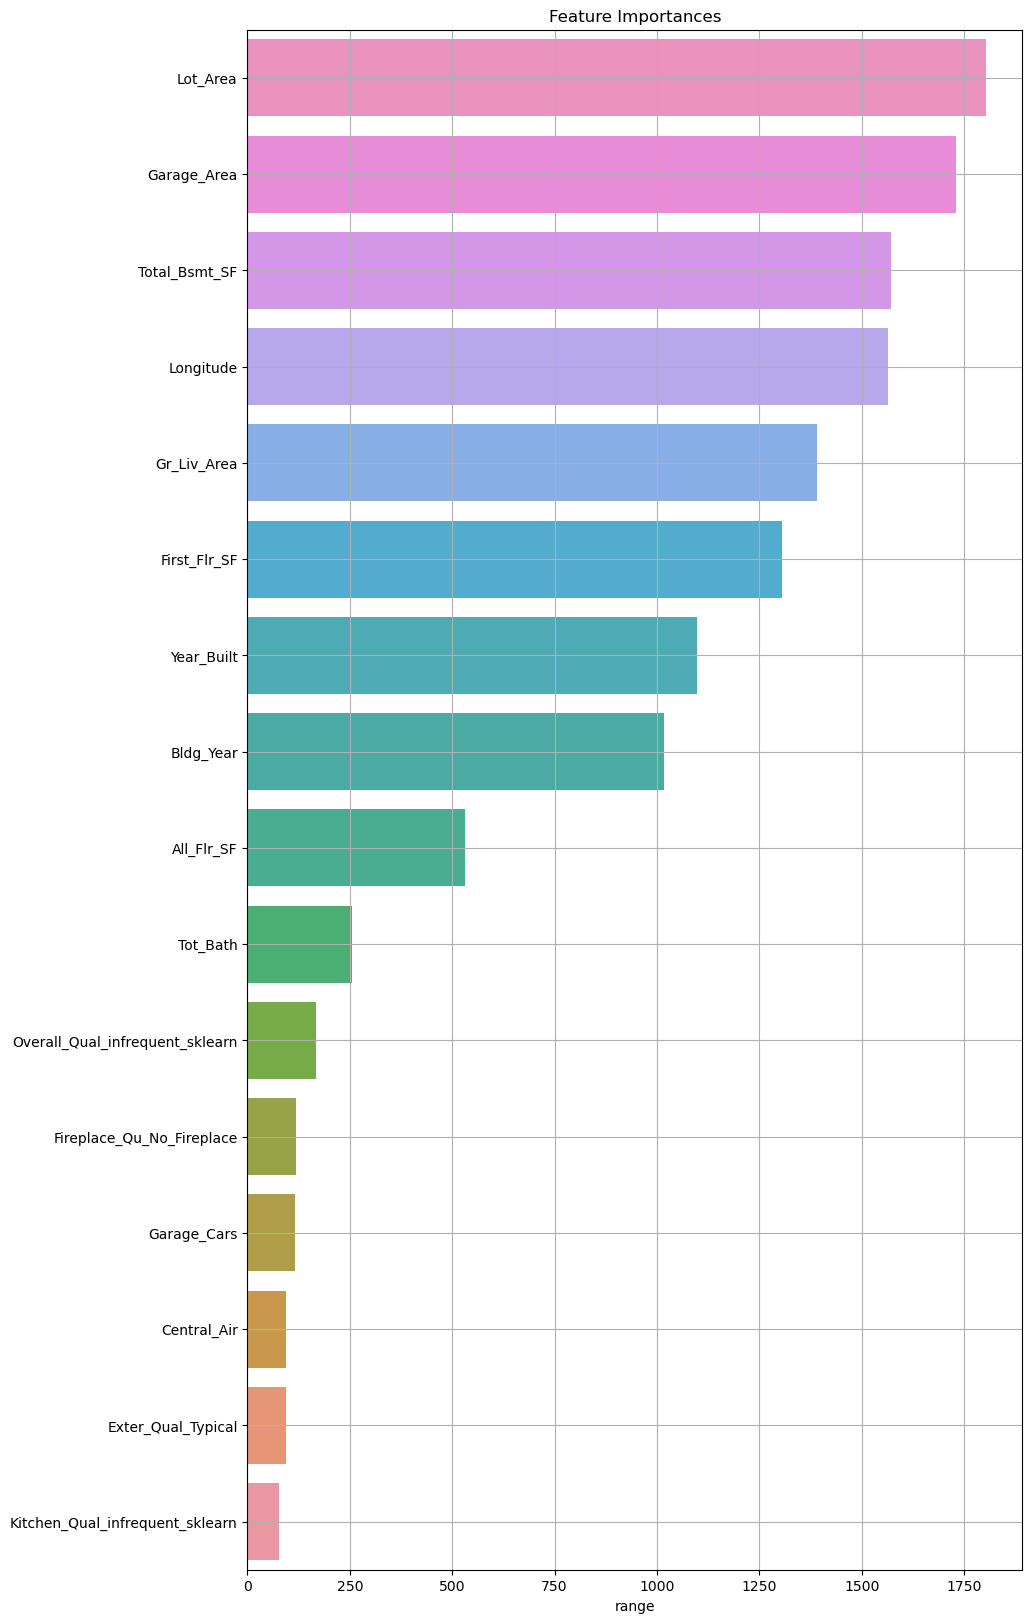

In [3]:

import seaborn as sns
X = X_train
y = y_train
l = lgb.LGBMRegressor(n_estimators=431, n_jobs=-1)
l.fit(X,y)
d= {}
for i in range(0,X.shape[1]):
    d[X.columns[i]] = l.feature_importances_[i]
fig, ax = plt.subplots(figsize=(10,20))
#ax.barh(range(0,X.shape[1]),rf.feature_importances_)
feature_importance= pd.DataFrame({"range": l.feature_importances_,
                   "feature": X.columns })

sns.barplot(x='range',
            y=X.columns, data=feature_importance,
            order=feature_importance.sort_values('range').feature)
ax.set_title("Feature Importances")
#ax.set_yticklabels(X.columns )
#ax.set_yticks(range(0,X.shape[1]))
ax.invert_yaxis() 
ax.grid()

In [4]:
import lightgbm as lgb


light =  lgb.LGBMRegressor(n_estimators=431, n_jobs=-1)
light.fit(X_train,y_train)
acc = light.score(y=y_test, X=X_test)
print(f'max acc:{acc}')




max acc:0.8916770530933302


In [5]:
from sklearn.model_selection import RandomizedSearchCV

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node

parameters = {'n_estimators': range(2,2000,20),
               'num_leaves': range(2,1500,20),
               'min_data_in_leaf': range(1,2000,20),
               'max_depth': range(2,2000,100)}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
light =  lgb.LGBMRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
light_random = RandomizedSearchCV(estimator = light, param_distributions = parameters, n_iter = 2000, cv = 3, verbose=2,error_score='raise',  n_jobs = -1)
# Fit the random search model
light_random.fit(X_train, y_train)
params= light_random.best_params_
params

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[LightGBM] [Warning] min_data_in_leaf is set=61, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=61


{'num_leaves': 762,
 'n_estimators': 242,
 'min_data_in_leaf': 61,
 'max_depth': 1802}

In [6]:
params['n_estimators']

242

In [7]:
light =  lgb.LGBMRegressor(n_estimators= params['n_estimators'],
                            num_leaves= params['num_leaves'],
                            min_data_in_leaf = params['min_data_in_leaf'],
                            min_child_samples= None,
                            max_depth= params['max_depth'],
                            n_jobs=-1)
light.fit(X_train,y_train)
acc = light.score(y=y_test, X=X_test)
print(f'max acc:{acc}')

max acc:0.8909942633994336


## Valutazione del modello con il grafico dei residui

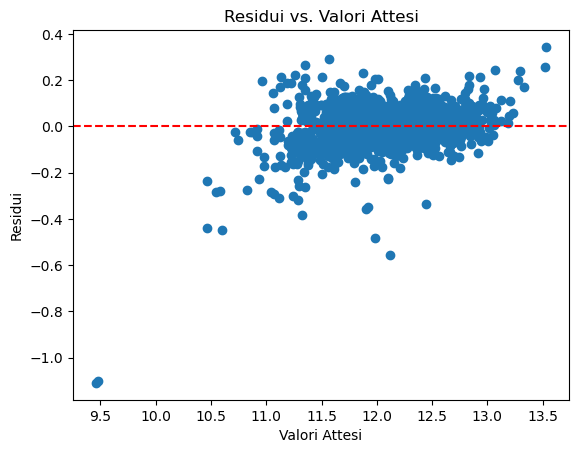

In [8]:
y_pred = light.predict(X_train)

residuals = y_train['Sale_Price'] - y_pred
plt.scatter(y_train, residuals)
plt.axhline(y=0, color='r', linestyle='--', label='Linea di Riferimento a Zero')  # Aggiungi la linea di riferimento
plt.xlabel('Valori Attesi')
plt.ylabel('Residui')
plt.title('Residui vs. Valori Attesi')
plt.show()



In [9]:
Q1 = np.percentile(residuals, 25)
Q3 = np.percentile(residuals, 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

anomalies = (residuals < lower_bound) | (residuals > upper_bound)
true_indices = np.where(anomalies)[0]
print(f'numero di valori anomali con i quantili = {len(true_indices)}')

# Stampa valori anomali
print(X_train.shape)
X_train.iloc[true_indices]



numero di valori anomali con i quantili = 107
(2051, 16)


,Lot_Area,Year_Built,Total_Bsmt_SF,Central_Air,First_Flr_SF,Gr_Liv_Area,Garage_Cars,Garage_Area,Longitude,Bldg_Year,Tot_Bath,All_Flr_SF,Overall_Qual_infrequent_sklearn,Exter_Qual_Typical,Kitchen_Qual_infrequent_sklearn,Fireplace_Qu_No_Fireplace
1,25095.0,1968.0,1437.0,1,1473.0,1473.0,1.0,452.0,-93.667980,-6.0,3.0,1473.0,0.0,1.0,1.0,0.0
8,32668.0,1957.0,2035.0,1,2515.0,2515.0,2.0,484.0,-93.643429,-32.0,4.0,2515.0,0.0,0.0,0.0,0.0
27,12085.0,2007.0,1734.0,1,1734.0,1734.0,3.0,928.0,-93.656640,0.0,3.0,1734.0,1.0,0.0,1.0,0.0
31,11475.0,1958.0,1584.0,1,1776.0,1776.0,3.0,888.0,-93.623411,-51.0,3.0,1776.0,0.0,1.0,0.0,1.0
33,1894.0,1970.0,546.0,1,546.0,1092.0,1.0,286.0,-93.602345,-36.0,2.0,1092.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1866,7200.0,1910.0,1214.0,0,1260.0,2291.0,2.0,506.0,-93.612191,-9.0,3.0,2291.0,0.0,1.0,0.0,0.0
1874,5925.0,1910.0,600.0,0,600.0,968.0,0.0,0.0,-93.606841,-59.0,1.0,968.0,1.0,1.0,0.0,1.0
1921,7038.0,1970.0,864.0,1,864.0,864.0,2.0,576.0,-93.627037,-39.0,2.0,864.0,1.0,1.0,0.0,1.0
1990,11606.0,1969.0,1040.0,1,1040.0,2080.0,2.0,504.0,-93.605388,-38.0,4.0,2080.0,0.0,1.0,1.0,0.0


In [10]:
import copy
anomal = np.where((residuals < -0.6))[0]
Y_train=  np.exp(y_train)
print(X_train.iloc[anomal])
print(Y_train.iloc[anomal])
Y_train.sort_values('Sale_Price')


     Lot_Area  Year_Built  Total_Bsmt_SF  Central_Air  First_Flr_SF  \
560   14584.0      1952.0            0.0            0         733.0   
860    9656.0      1923.0          678.0            0         832.0   

     Gr_Liv_Area  Garage_Cars  Garage_Area  Longitude  Bldg_Year  Tot_Bath  \
560        733.0          2.0        487.0 -93.625217      -56.0       1.0   
860        832.0          2.0        780.0 -93.606789      -40.0       1.0   

     All_Flr_SF  Overall_Qual_infrequent_sklearn  Exter_Qual_Typical  \
560       733.0                              1.0                 0.0   
860       832.0                              1.0                 1.0   

     Kitchen_Qual_infrequent_sklearn  Fireplace_Qu_No_Fireplace  
560                              1.0                        1.0  
860                              0.0                        0.0  
     Sale_Price
560     13100.0
860     12789.0


,Sale_Price
860,12789.0
560,13100.0
651,34900.0
1355,35000.0
1874,37900.0
...,...
1822,584500.0
585,591587.0
1236,615000.0
158,745000.0


Notiamo come nei valori anomali ottenuti con il grafico dei residui, comparando al Y_train sortato, sono rispettivamente i due valori aventi Sale_Price minore.
Dunque la LightGBM non riesce a valutare bene per valori di Sale_Price molto piccoli rispetto al dataset.
Analizzando invece altre correlazioni inerenti ai due valori anomali, non sono stati trovati evidenti correlazioni che possano influire sulla predizione di questo modello eccetto il Sale_Price